In [1]:
# 1: Instalacja i import niezbędnych bibliotek

# Import bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import mlflow
import mlflow.sklearn
import shap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, classification_report
)
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tqdm import tqdm
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mlflow.models.signature import infer_signature
import optuna
import joblib
import warnings

warnings.filterwarnings("ignore")

# Tworzenie potrzebnych katalogów
os.makedirs("../results", exist_ok=True)
os.makedirs("../reports", exist_ok=True)
os.makedirs("../models", exist_ok=True)

# Ustawienie stylu dla wykresów
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Konfiguracja MLflow
mlflow.set_tracking_uri("http://localhost:5000")  # Zmień na adres swojego serwera MLflow
experiment_name = "Heart_Disease_Classification_docker_1"  # Nazwa eksperymentu
mlflow.set_experiment(experiment_name)

print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment ID: {mlflow.get_experiment_by_name(experiment_name).experiment_id}")

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


MLflow Tracking URI: http://localhost:5000
Experiment ID: 153145805922288053


In [2]:
# 2: Wczytywanie danych przygotowanych wcześniej

# Wczytywanie danych treningowych i testowych
train_data = pd.read_csv("../data/processed/heart_train.csv")
test_data = pd.read_csv("../data/processed/heart_test.csv")

# Podział na cechy i etykietę (target)
X_train = train_data.drop("HeartDisease", axis=1)
y_train = train_data["HeartDisease"].map({"No": 0, "Yes": 1})

X_test = test_data.drop("HeartDisease", axis=1)
y_test = test_data["HeartDisease"].map({"No": 0, "Yes": 1})

In [3]:
# 3: Przygotowanie danych – identyfikacja kolumn

# Identyfikacja kolumn kategorycznych i numerycznych
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Kolumny kategoryczne:", categorical_cols)
print("Kolumny numeryczne:", numerical_cols)
print(f"Wymiary zbioru treningowego: {X_train.shape}")
print(f"Wymiary zbioru testowego: {X_test.shape}")

Kolumny kategoryczne: ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']
Kolumny numeryczne: ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
Wymiary zbioru treningowego: (255836, 17)
Wymiary zbioru testowego: (63959, 17)


In [4]:
# 4: Przygotowanie pipeline do przetwarzania danych

# Definiowanie preprocessingu dla kolumn numerycznych
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Definiowanie preprocessingu dla kolumn kategorycznych
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Połączenie transformerów w jeden preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Funkcja do tworzenia pipeline'u modelu
def create_model_pipeline(classifier):
    """Tworzy pipeline dla modelu, który zawiera preprocessor i klasyfikator."""
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

In [5]:
# 5: Trenowanie modeli i logowanie wyników do MLflow

# Lista klasyfikatorów do przetestowania
classifiers = {
    "LinearSVC": LinearSVC(random_state=42, max_iter=20000),
    "KNN": KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', n_jobs=-1),
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1),
    "RandomForestClassifier": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(),
    "LGBMClassifier": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "RidgeClassifier": RidgeClassifier(),
    "NaiveBayes": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis()
}

# Słownik do przechowywania wyników
results = {}

# Funkcja do logowania modelu i metryk do MLflow
def log_model_to_mlflow(model, model_name, pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)

    if hasattr(pipeline, "predict_proba"):
        y_prob = pipeline.predict_proba(X_test)[:, 1]
    elif hasattr(pipeline, "decision_function"):
        y_prob = pipeline.decision_function(X_test)
    else:
        y_prob = None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    with mlflow.start_run(run_name=model_name, nested=True):
        for param_name, param_value in model.get_params().items():
            mlflow.log_param(param_name, param_value)

        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        cm_path = f"../results/confusion_matrix_{model_name}.png"
        plt.savefig(cm_path)
        plt.close()
        mlflow.log_artifact(cm_path)

        # ROC Curve
        if y_prob is not None:
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)

            plt.figure(figsize=(10, 8))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {model_name}')
            plt.legend(loc="lower right")
            roc_path = f"../results/roc_curve_{model_name}.png"
            plt.savefig(roc_path)
            plt.close()
            mlflow.log_artifact(roc_path)
            mlflow.log_metric("roc_auc", roc_auc)
        else:
            roc_auc = None

        signature = infer_signature(X_test, y_pred)

        # Bezpieczne logowanie modelu + artefaktu lokalnie
        local_model_path = f"../models/{model_name}_model.pkl"
        joblib.dump(pipeline, local_model_path)

        # Log lokalnego pliku jako artefakt (nie przez API model registry)
        mlflow.log_artifact(local_model_path)

        # Próbuj logować do MLflow registry, ale jeśli serwer zamknie połączenie – pomiń
        try:
            mlflow.sklearn.log_model(
                pipeline,
                f"{model_name}_model",
                input_example=X_test.iloc[:1],
                signature=signature
            )
            mlflow.register_model(
                model_uri=f"runs:/{mlflow.active_run().info.run_id}/{model_name}_model",
                name=model_name
            )
        except Exception as e:
            print(f"⚠️ Nie udało się zarejestrować modelu {model_name} w MLflow Model Registry: {e}")

        # Classification report
        clf_report = classification_report(y_test, y_pred, output_dict=True)
        clf_df = pd.DataFrame(clf_report).transpose()
        clf_path = f"../reports/classification_report_{model_name}.csv"
        clf_df.to_csv(clf_path)
        mlflow.log_artifact(clf_path)

        return {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "roc_auc": roc_auc
        }

# Trenowanie i logowanie modeli
for name, classifier in tqdm(classifiers.items(), desc="Trenowanie modeli"):
    print(f"\nTrenowanie modelu: {name}")
    pipeline = create_model_pipeline(classifier)
    pipeline.fit(X_train, y_train)
    result = log_model_to_mlflow(classifier, name, pipeline, X_test, y_test)
    results[name] = result
    print(f"Model: {name}, Accuracy: {result['accuracy']:.4f}, F1 Score: {result['f1_score']:.4f}")

Trenowanie modeli:   0%|                                                                                                                | 0/11 [00:00<?, ?it/s]


Trenowanie modelu: LinearSVC


Registered model 'LinearSVC' already exists. Creating a new version of this model...
2025/05/15 15:37:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LinearSVC, version 2
Created version '2' of model 'LinearSVC'.
Trenowanie modeli:   9%|█████████▎                                                                                             | 1/11 [04:38<46:21, 278.17s/it]

🏃 View run LinearSVC at: http://localhost:5000/#/experiments/153145805922288053/runs/592d387f36a94261bb9245e1c39069c3
🧪 View experiment at: http://localhost:5000/#/experiments/153145805922288053
Model: LinearSVC, Accuracy: 0.9136, F1 Score: 0.8777

Trenowanie modelu: KNN


Registered model 'KNN' already exists. Creating a new version of this model...
2025/05/15 15:40:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: KNN, version 2
Created version '2' of model 'KNN'.
Trenowanie modeli:  18%|██████████████████▋                                                                                    | 2/11 [07:32<32:35, 217.28s/it]

🏃 View run KNN at: http://localhost:5000/#/experiments/153145805922288053/runs/3eb0917064974d7993ba73e9e89f32db
🧪 View experiment at: http://localhost:5000/#/experiments/153145805922288053
Model: KNN, Accuracy: 0.9044, F1 Score: 0.8818

Trenowanie modelu: LogisticRegression


Registered model 'LogisticRegression' already exists. Creating a new version of this model...
2025/05/15 15:40:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 2
Created version '2' of model 'LogisticRegression'.
Trenowanie modeli:  27%|████████████████████████████                                                                           | 3/11 [07:42<16:19, 122.49s/it]

🏃 View run LogisticRegression at: http://localhost:5000/#/experiments/153145805922288053/runs/e6254ec1f1de49dd97e5f0d7a310ec5e
🧪 View experiment at: http://localhost:5000/#/experiments/153145805922288053
Model: LogisticRegression, Accuracy: 0.9139, F1 Score: 0.8859

Trenowanie modelu: RandomForestClassifier


Registered model 'RandomForestClassifier' already exists. Creating a new version of this model...
2025/05/15 15:41:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestClassifier, version 2
Created version '2' of model 'RandomForestClassifier'.
Trenowanie modeli:  36%|█████████████████████████████████████▊                                                                  | 4/11 [08:32<10:57, 93.92s/it]

🏃 View run RandomForestClassifier at: http://localhost:5000/#/experiments/153145805922288053/runs/7ef58039b29b477691db9467bdcf5884
🧪 View experiment at: http://localhost:5000/#/experiments/153145805922288053
Model: RandomForestClassifier, Accuracy: 0.9015, F1 Score: 0.8813

Trenowanie modelu: XGBoost


Registered model 'XGBoost' already exists. Creating a new version of this model...
2025/05/15 15:41:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost, version 2
Created version '2' of model 'XGBoost'.
Trenowanie modeli:  45%|███████████████████████████████████████████████▎                                                        | 5/11 [08:44<06:26, 64.34s/it]

🏃 View run XGBoost at: http://localhost:5000/#/experiments/153145805922288053/runs/5a3a03ce82c04582ae0cf1e06fbbfd04
🧪 View experiment at: http://localhost:5000/#/experiments/153145805922288053
Model: XGBoost, Accuracy: 0.9126, F1 Score: 0.8846

Trenowanie modelu: GradientBoosting


Registered model 'GradientBoosting' already exists. Creating a new version of this model...
2025/05/15 15:42:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GradientBoosting, version 2
Created version '2' of model 'GradientBoosting'.
Trenowanie modeli:  55%|████████████████████████████████████████████████████████▋                                               | 6/11 [09:38<05:03, 60.66s/it]

🏃 View run GradientBoosting at: http://localhost:5000/#/experiments/153145805922288053/runs/e9d37f24264f40fba1721410cc5da5e8
🧪 View experiment at: http://localhost:5000/#/experiments/153145805922288053
Model: GradientBoosting, Accuracy: 0.9140, F1 Score: 0.8846

Trenowanie modelu: LGBMClassifier
[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518


Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
2025/05/15 15:42:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBMClassifier, version 2
Created version '2' of model 'LGBMClassifier'.
Trenowanie modeli:  64%|██████████████████████████████████████████████████████████████████▏                                     | 7/11 [09:48<02:56, 44.21s/it]

🏃 View run LGBMClassifier at: http://localhost:5000/#/experiments/153145805922288053/runs/05c0b831e28242dc917d72397f474c0b
🧪 View experiment at: http://localhost:5000/#/experiments/153145805922288053
Model: LGBMClassifier, Accuracy: 0.9144, F1 Score: 0.8834

Trenowanie modelu: CatBoost


Registered model 'CatBoost' already exists. Creating a new version of this model...
2025/05/15 15:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: CatBoost, version 2
Created version '2' of model 'CatBoost'.
Trenowanie modeli:  73%|███████████████████████████████████████████████████████████████████████████▋                            | 8/11 [11:11<02:49, 56.49s/it]

🏃 View run CatBoost at: http://localhost:5000/#/experiments/153145805922288053/runs/d39ffe57a8e44c8794443638689bcd8f
🧪 View experiment at: http://localhost:5000/#/experiments/153145805922288053
Model: CatBoost, Accuracy: 0.9136, F1 Score: 0.8852

Trenowanie modelu: RidgeClassifier


Registered model 'RidgeClassifier' already exists. Creating a new version of this model...
2025/05/15 15:43:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RidgeClassifier, version 2
Created version '2' of model 'RidgeClassifier'.
Trenowanie modeli:  82%|█████████████████████████████████████████████████████████████████████████████████████                   | 9/11 [11:21<01:23, 41.96s/it]

🏃 View run RidgeClassifier at: http://localhost:5000/#/experiments/153145805922288053/runs/2584cf17a26441c48ea4a2bebab98ca9
🧪 View experiment at: http://localhost:5000/#/experiments/153145805922288053
Model: RidgeClassifier, Accuracy: 0.9135, F1 Score: 0.8765

Trenowanie modelu: NaiveBayes


Registered model 'NaiveBayes' already exists. Creating a new version of this model...
2025/05/15 15:44:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: NaiveBayes, version 2
Created version '2' of model 'NaiveBayes'.
Trenowanie modeli:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▋         | 10/11 [11:27<00:31, 31.10s/it]

🏃 View run NaiveBayes at: http://localhost:5000/#/experiments/153145805922288053/runs/90652a30f39b456d8402a09a6a054d07
🧪 View experiment at: http://localhost:5000/#/experiments/153145805922288053
Model: NaiveBayes, Accuracy: 0.7514, F1 Score: 0.8024

Trenowanie modelu: LDA


Registered model 'LDA' already exists. Creating a new version of this model...
2025/05/15 15:44:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LDA, version 2
Created version '2' of model 'LDA'.
Trenowanie modeli: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [11:37<00:00, 63.39s/it]

🏃 View run LDA at: http://localhost:5000/#/experiments/153145805922288053/runs/5e82555d959b42848e455d484552996b
🧪 View experiment at: http://localhost:5000/#/experiments/153145805922288053
Model: LDA, Accuracy: 0.9056, F1 Score: 0.8935



Podsumowanie wyników wszystkich modeli:
                        accuracy  precision    recall  f1_score   roc_auc
LinearSVC               0.913632   0.887148  0.913632  0.877710  0.835893
KNN                     0.904439   0.871527  0.904439  0.881842  0.700058
LogisticRegression      0.913882   0.886850  0.913882  0.885902  0.836447
RandomForestClassifier  0.901468   0.870454  0.901468  0.881343  0.780491
XGBoost                 0.912632   0.883096  0.912632  0.884609  0.834313
GradientBoosting        0.914023   0.887062  0.914023  0.884626  0.838015
LGBMClassifier          0.914383   0.888558  0.914383  0.883427  0.839838
CatBoost                0.913570   0.885779  0.913570  0.885231  0.837904
RidgeClassifier         0.913523   0.887622  0.913523  0.876549  0.831087
NaiveBayes              0.751403   0.900465  0.751403  0.802404  0.813236
LDA                     0.905596   0.886599  0.905596  0.893482  0.831087
🏃 View run Model_Comparison_Summary at: http://localhost:5000/#/experim

<Figure size 1200x800 with 0 Axes>

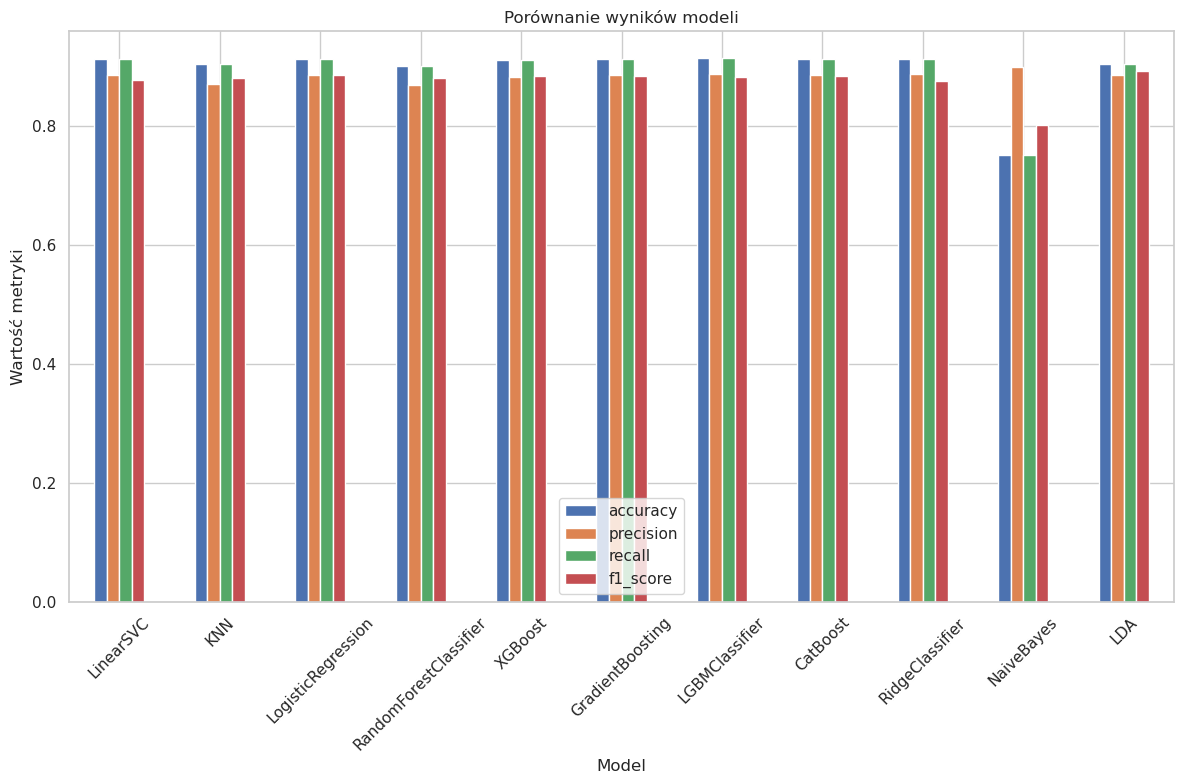

In [6]:
# 6: Porównanie wyników modeli

# Porównanie wyników wszystkich modeli
results_df = pd.DataFrame(results).T
print("\nPodsumowanie wyników wszystkich modeli:")
print(results_df)

# Zapis wyników do pliku CSV i logowanie jako artefakt do MLflow
results_csv_path = "../reports/model_results_summary.csv"
results_df.to_csv(results_csv_path)
with mlflow.start_run(run_name="Model_Comparison_Summary", nested=True):
    mlflow.log_artifact(results_csv_path)

# Wizualizacja porównania metryk
plt.figure(figsize=(12, 8))
results_df[['accuracy', 'precision', 'recall', 'f1_score']].plot(kind='bar')
plt.title('Porównanie wyników modeli')
plt.xlabel('Model')
plt.ylabel('Wartość metryki')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../results/model_comparison.png")
plt.show()

In [7]:
# 7: Tuning hiperparametrów najlepszego modelu (Optuna)

# Wybór najlepszego modelu na podstawie accuracy
best_model_name = results_df['accuracy'].idxmax()
print(f"\nNajlepszy model: {best_model_name} z accuracy: {results_df.loc[best_model_name, 'accuracy']:.4f}")

# Funkcja celu Optuny
def optuna_objective(trial):
    if best_model_name == "RandomForestClassifier":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 5, 30),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4)
        }
        model = RandomForestClassifier(random_state=42, **params)

    elif best_model_name == "XGBoost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0)
        }
        model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42, **params)

    elif best_model_name == "LGBMClassifier":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3)
        }
        model = LGBMClassifier(random_state=42, **params)

    elif best_model_name == "CatBoost":
        params = {
            "iterations": trial.suggest_int("iterations", 100, 500),
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3)
        }
        model = CatBoostClassifier(verbose=0, random_state=42, **params)

    elif best_model_name == "GradientBoosting":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0)
        }
        model = GradientBoostingClassifier(random_state=42, **params)
    else:
        raise ValueError("Model nieobsługiwany przez Optuna.")

    # Pipeline i predykcje
    pipeline = create_model_pipeline(model)
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    # Zwrotka dla Optuny — f1 jako metryka
    return f1_score(y_test, preds, average='weighted')

# Uruchomienie Optuny
study = optuna.create_study(direction="maximize")
study.optimize(optuna_objective, n_trials=30)

# Najlepsze parametry i model
best_params = study.best_trial.params
print(f"\nNajlepsze parametry znalezione przez Optunę: {best_params}")

# Odtworzenie najlepszego modelu
if best_model_name == "RandomForestClassifier":
    final_model = RandomForestClassifier(random_state=42, **best_params)
elif best_model_name == "XGBoost":
    final_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, **best_params)
elif best_model_name == "LGBMClassifier":
    final_model = LGBMClassifier(random_state=42, **best_params)
elif best_model_name == "CatBoost":
    final_model = CatBoostClassifier(verbose=0, random_state=42, **best_params)
elif best_model_name == "GradientBoosting":
    final_model = GradientBoostingClassifier()
elif best_model_name == "KNN":
    final_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', n_jobs=-1)
elif best_model_name == "LinearSVC":
    final_model = LinearSVC(random_state=42, max_iter=20000)
elif best_model_name == "LogisticRegression":
    final_model = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
elif best_model_name == "RidgeClassifier":
    final_model = RidgeClassifier()
elif best_model_name == "NaiveBayes":
    final_model = GaussianNB()
elif best_model_name == "LDA":
    final_model = LinearDiscriminantAnalysis()
else:
    raise ValueError("Brak implementacji final_model dla wybranego modelu.")

# Trenowanie finalnego pipeline
final_pipeline = create_model_pipeline(final_model)
final_pipeline.fit(X_train, y_train)
y_pred = final_pipeline.predict(X_test)

# Metryki końcowe
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='weighted')
test_recall = recall_score(y_test, y_pred, average='weighted')
test_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nMetryki modelu po tuningu Optuna:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Wykres SHAP tylko dla modeli wspieranych
if best_model_name in ["XGBoost", "LGBMClassifier", "CatBoost", "RandomForestClassifier"]:
    X_transformed = final_pipeline.named_steps['preprocessor'].transform(X_test)

    explainer = shap.Explainer(final_pipeline.named_steps['classifier'], X_transformed)
    shap_values = explainer(X_transformed, check_additivity=False)

    plt.figure()
    shap.summary_plot(
        shap_values,
        features=X_transformed,
        feature_names=final_pipeline.named_steps['preprocessor'].get_feature_names_out(),
        show=False
    )
    shap_path = f"../results/shap_summary_{best_model_name}.png"
    plt.savefig(shap_path, bbox_inches="tight")
    plt.close()

    # Logowanie wykresu SHAP jako artefakt
    with mlflow.start_run(run_name=f"SHAP_{best_model_name}", nested=True):
        mlflow.log_artifact(shap_path)

[I 2025-05-15 15:44:14,598] A new study created in memory with name: no-name-49c15932-d298-48d3-a356-4fb8661f1d8d



Najlepszy model: LGBMClassifier z accuracy: 0.9144
[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518


[I 2025-05-15 15:44:19,917] Trial 0 finished with value: 0.8843007031944407 and parameters: {'n_estimators': 160, 'max_depth': 6, 'learning_rate': 0.261694331511807}. Best is trial 0 with value: 0.8843007031944407.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-15 15:44:23,439] Trial 1 finished with value: 0.8827862531943282 and parameters: {'n_estimators': 106, 'max_depth': 5, 'learning_rate': 0.084160949368216}. Best is trial 0 with value: 0.8843007031944407.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518


[I 2025-05-15 15:44:26,368] Trial 2 finished with value: 0.8837770721403594 and parameters: {'n_estimators': 66, 'max_depth': 8, 'learning_rate': 0.21397017846968738}. Best is trial 0 with value: 0.8843007031944407.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-15 15:44:29,700] Trial 3 finished with value: 0.8841187092595877 and parameters: {'n_estimators': 124, 'max_depth': 3, 'learning_rate': 0.1869876286501876}. Best is trial 0 with value: 0.8843007031944407.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-15 15:44:35,911] Trial 4 finished with value: 0.8845498629761052 and parameters: {'n_estimators': 238, 'max_depth': 5, 'learning_rate': 0.09418139656105302}. Best is trial 4 with value: 0.8845498629761052.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518


[I 2025-05-15 15:44:41,074] Trial 5 finished with value: 0.8844519523963966 and parameters: {'n_estimators': 248, 'max_depth': 8, 'learning_rate': 0.17917478598729614}. Best is trial 4 with value: 0.8845498629761052.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518


[I 2025-05-15 15:44:46,949] Trial 6 finished with value: 0.8848699767721101 and parameters: {'n_estimators': 282, 'max_depth': 7, 'learning_rate': 0.20232537645055973}. Best is trial 6 with value: 0.8848699767721101.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518


[I 2025-05-15 15:44:49,927] Trial 7 finished with value: 0.8835734062359373 and parameters: {'n_estimators': 74, 'max_depth': 8, 'learning_rate': 0.13401157695304436}. Best is trial 6 with value: 0.8848699767721101.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-05-15 15:44:55,758] Trial 8 finished with value: 0.8846787252695992 and parameters: {'n_estimators': 256, 'max_depth': 6, 'learning_rate': 0.19531536240862618}. Best is trial 6 with value: 0.8848699767721101.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518


[I 2025-05-15 15:45:01,712] Trial 9 finished with value: 0.8842530858019204 and parameters: {'n_estimators': 219, 'max_depth': 7, 'learning_rate': 0.11758206292952549}. Best is trial 6 with value: 0.8848699767721101.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518


[I 2025-05-15 15:45:11,344] Trial 10 finished with value: 0.8831369945850132 and parameters: {'n_estimators': 299, 'max_depth': 10, 'learning_rate': 0.026058501022450442}. Best is trial 6 with value: 0.8848699767721101.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-15 15:45:17,662] Trial 11 finished with value: 0.8848320959969405 and parameters: {'n_estimators': 292, 'max_depth': 4, 'learning_rate': 0.291200330518836}. Best is trial 6 with value: 0.8848699767721101.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-15 15:45:23,289] Trial 12 finished with value: 0.8851350915170182 and parameters: {'n_estimators': 297, 'max_depth': 3, 'learning_rate': 0.2937094006906439}. Best is trial 12 with value: 0.8851350915170182.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-15 15:45:27,617] Trial 13 finished with value: 0.8854265145407526 and parameters: {'n_estimators': 198, 'max_depth': 3, 'learning_rate': 0.24911258439597198}. Best is trial 13 with value: 0.8854265145407526.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-15 15:45:31,743] Trial 14 finished with value: 0.8848108255982451 and parameters: {'n_estimators': 190, 'max_depth': 3, 'learning_rate': 0.2552537232348226}. Best is trial 13 with value: 0.8854265145407526.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-15 15:45:36,546] Trial 15 finished with value: 0.8838603694318918 and parameters: {'n_estimators': 194, 'max_depth': 4, 'learning_rate': 0.2993076977878607}. Best is trial 13 with value: 0.8854265145407526.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-15 15:45:39,979] Trial 16 finished with value: 0.884764806568188 and parameters: {'n_estimators': 127, 'max_depth': 3, 'learning_rate': 0.2361415458839324}. Best is trial 13 with value: 0.8854265145407526.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-15 15:45:45,525] Trial 17 finished with value: 0.8843274547183584 and parameters: {'n_estimators': 163, 'max_depth': 4, 'learning_rate': 0.25716535454738704}. Best is trial 13 with value: 0.8854265145407526.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-15 15:45:50,791] Trial 18 finished with value: 0.8845363449417991 and parameters: {'n_estimators': 215, 'max_depth': 5, 'learning_rate': 0.2796593173016964}. Best is trial 13 with value: 0.8854265145407526.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-15 15:45:56,033] Trial 19 finished with value: 0.885113671568185 and parameters: {'n_estimators': 269, 'max_depth': 3, 'learning_rate': 0.22183026879402584}. Best is trial 13 with value: 0.8854265145407526.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518


[I 2025-05-15 15:46:00,960] Trial 20 finished with value: 0.8840136519020926 and parameters: {'n_estimators': 226, 'max_depth': 10, 'learning_rate': 0.16064479809551563}. Best is trial 13 with value: 0.8854265145407526.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-15 15:46:06,267] Trial 21 finished with value: 0.8846952617304891 and parameters: {'n_estimators': 266, 'max_depth': 3, 'learning_rate': 0.22494251633848156}. Best is trial 13 with value: 0.8854265145407526.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-15 15:46:12,418] Trial 22 finished with value: 0.8843532225645074 and parameters: {'n_estimators': 270, 'max_depth': 4, 'learning_rate': 0.23898243010344555}. Best is trial 13 with value: 0.8854265145407526.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-15 15:46:18,214] Trial 23 finished with value: 0.8852382618671778 and parameters: {'n_estimators': 299, 'max_depth': 3, 'learning_rate': 0.27666567693047844}. Best is trial 13 with value: 0.8854265145407526.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-15 15:46:24,289] Trial 24 finished with value: 0.8850774556389831 and parameters: {'n_estimators': 291, 'max_depth': 4, 'learning_rate': 0.2744656463096272}. Best is trial 13 with value: 0.8854265145407526.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-15 15:46:29,463] Trial 25 finished with value: 0.8842030360379606 and parameters: {'n_estimators': 197, 'max_depth': 5, 'learning_rate': 0.2729915582049069}. Best is trial 13 with value: 0.8854265145407526.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-15 15:46:34,371] Trial 26 finished with value: 0.8853217704996194 and parameters: {'n_estimators': 241, 'max_depth': 3, 'learning_rate': 0.2423064586581624}. Best is trial 13 with value: 0.8854265145407526.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-15 15:46:39,848] Trial 27 finished with value: 0.8851767394171206 and parameters: {'n_estimators': 237, 'max_depth': 4, 'learning_rate': 0.2494837026548225}. Best is trial 13 with value: 0.8854265145407526.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-05-15 15:46:44,184] Trial 28 finished with value: 0.8847671153786448 and parameters: {'n_estimators': 174, 'max_depth': 3, 'learning_rate': 0.16855843238598694}. Best is trial 13 with value: 0.8854265145407526.


[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518


[I 2025-05-15 15:46:48,185] Trial 29 finished with value: 0.8852488201929191 and parameters: {'n_estimators': 148, 'max_depth': 6, 'learning_rate': 0.26894115361526505}. Best is trial 13 with value: 0.8854265145407526.



Najlepsze parametry znalezione przez Optunę: {'n_estimators': 198, 'max_depth': 3, 'learning_rate': 0.24911258439597198}
[LightGBM] [Info] Number of positive: 21781, number of negative: 234055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085137 -> initscore=-2.374518
[LightGBM] [Info] Start training from score -2.374518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

100%|===================| 63934/63959 [01:30<00:00]        

🏃 View run SHAP_LGBMClassifier at: http://localhost:5000/#/experiments/153145805922288053/runs/349843cd3e6f4cfdb36d747e6a5a4203
🧪 View experiment at: http://localhost:5000/#/experiments/153145805922288053


In [8]:
# 8: Zapis najlepszego modelu do pliku

# Zapisanie finalnego pipeline z najlepszymi parametrami do pliku
model_path = f"../models/{best_model_name}_best_model.pkl"
joblib.dump(final_pipeline, model_path)

print(f"\nNajlepszy model zapisany do: {model_path}")


Najlepszy model zapisany do: ../models/LGBMClassifier_best_model.pkl


In [9]:
# 9: Predict pipeline – generowanie predykcji

def predict_pipeline(data_to_predict, model_path):
    """
    Przetwarzanie nowych danych i generowanie predykcji.
    
    Args:
        data_to_predict: DataFrame z nowymi danymi
        model_path: Ścieżka do zapisanego modelu
    
    Returns:
        DataFrame z predykcjami i prawdopodobieństwami (jeśli dostępne)
    """
    # Wczytanie modelu
    loaded_model = joblib.load(model_path)

    # Generowanie predykcji
    predictions = loaded_model.predict(data_to_predict)

    # Prawdopodobieństwa (jeśli dostępne)
    if hasattr(loaded_model, "predict_proba"):
        probabilities = loaded_model.predict_proba(data_to_predict)[:, 1]
        return pd.DataFrame({
            'prediction': predictions,
            'probability': probabilities
        })
    else:
        return pd.DataFrame({
            'prediction': predictions
        })

# Przykład użycia na 5 próbkach
print("\nDemonstracja działania predict pipeline:")
sample_data = X_test.iloc[:5]
predictions = predict_pipeline(sample_data, model_path)
print(predictions)


Demonstracja działania predict pipeline:
   prediction  probability
0           0     0.004943
1           0     0.003119
2           0     0.010464
3           0     0.074050
4           0     0.196058


In [10]:
# 10: Podsumowanie projektu

# Podsumowanie
print("\nPodsumowanie projektu:")
print(f"1. Najlepszy model: {best_model_name}")
print(f"2. Najlepsze parametry (Optuna): {best_params}")
print(f"3. Accuracy najlepszego modelu: {test_accuracy:.4f}")
print(f"4. F1 Score najlepszego modelu: {test_f1:.4f}")
print(f"5. Precision najlepszego modelu: {test_precision:.4f}")
print(f"6. Recall najlepszego modelu: {test_recall:.4f}")

print("\nWszystkie eksperymenty i wyniki są dostępne w MLflow pod adresem:")
print(f"MLflow UI: {mlflow.get_tracking_uri()}")
print(f"Experiment ID: {mlflow.get_experiment_by_name(experiment_name).experiment_id}")


Podsumowanie projektu:
1. Najlepszy model: LGBMClassifier
2. Najlepsze parametry (Optuna): {'n_estimators': 198, 'max_depth': 3, 'learning_rate': 0.24911258439597198}
3. Accuracy najlepszego modelu: 0.9144
4. F1 Score najlepszego modelu: 0.8854
5. Precision najlepszego modelu: 0.8883
6. Recall najlepszego modelu: 0.9144

Wszystkie eksperymenty i wyniki są dostępne w MLflow pod adresem:
MLflow UI: http://localhost:5000
Experiment ID: 153145805922288053


In [11]:
# 11: Zakończenie
print("\nProjekt zakończony sukcesem!")


Projekt zakończony sukcesem!
